In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/caltech256")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/caltech256


In [2]:
from pathlib import Path

from torchvision.models import resnet18, efficientnet_b0

root_dir = path + '/256_ObjectCategories'

def get_folder_frequency_list(root_dir):
    folder_frequency_list = []

    root_path = Path(root_dir)

    for folder in sorted(root_path.iterdir()):
        if folder.is_dir():
            file_count = sum(1 for item in folder.iterdir() if item.is_file())
            folder_frequency_list.extend([folder.name.split('.')[0]] * file_count)

    return folder_frequency_list

targets = get_folder_frequency_list(root_dir)
targets_int = [int(x) for i,x in enumerate(targets)]


In [3]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

root_dir = '/kaggle/input/'

transform1 = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    # transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

inception_dataset = datasets.Caltech256(root=root_dir, transform = transform1, target_transform = None,  download=False)
resnet_dataset = datasets.Caltech256(root=root_dir, transform=transform2, target_transform=None, download= False)

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch

indices = np.arange(len(inception_dataset))

if len(indices) != len(targets_int):
    del targets_int[0]
    targets_int = np.array(targets_int)

train_indices, temp_indices, _, _ = train_test_split(indices, targets_int, test_size=0.3, stratify=targets_int, random_state=42)

val_indices, test_indices, _, _ = train_test_split(temp_indices, [targets_int[i] for i in temp_indices], test_size=0.5, stratify=[targets_int[i] for i in temp_indices], random_state=42)

train_dataset = torch.utils.data.Subset(inception_dataset, train_indices)
val_dataset = torch.utils.data.Subset(inception_dataset, val_indices)
test_dataset = torch.utils.data.Subset(inception_dataset, test_indices)


print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train size: 21424
Validation size: 4591
Test size: 4592


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch

indices = np.arange(len(resnet_dataset))

if len(indices) != len(targets_int):
    del targets_int[0]
    targets_int = np.array(targets_int)

train_indices, temp_indices, _, _ = train_test_split(indices, targets_int, test_size=0.3, stratify=targets_int, random_state=42)

val_indices, test_indices, _, _ = train_test_split(temp_indices, [targets_int[i] for i in temp_indices], test_size=0.5, stratify=[targets_int[i] for i in temp_indices], random_state=42)

train_dataset = torch.utils.data.Subset(resnet_dataset, train_indices)
val_dataset = torch.utils.data.Subset(resnet_dataset, val_indices)
test_dataset = torch.utils.data.Subset(resnet_dataset, test_indices)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

resnet_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
resnet_val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
resnet_test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Train size: 21424
Validation size: 4591
Test size: 4592


In [6]:
def topk_accuracy(model, loader, device, k=5):
    
    model.eval()
    correct_topk = 0
    total = 0

    with torch.no_grad():

        for images, labels in loader:
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, topk_preds = outputs.topk(k, dim=1) 

            correct_topk += sum([label in topk for topk, label in zip(topk_preds, labels)])
            total += labels.size(0)

    return correct_topk / total


In [7]:
import torch
import torch.nn as nn

class ResNetModule(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):

        super(ResNetModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
      
        identity = x

        pred = self.relu(self.bn1(self.conv1(x)))
        pred = self.relu(self.bn2(self.conv2(pred)))
        pred = self.bn3(self.conv3(pred))

        if self.downsample:
            identity = self.downsample(x)

        pred += identity
        pred = self.relu(pred)

        return pred






class myResNet50(nn.Module):

    def __init__(self):
        
        super(myResNet50, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(ResNetModule, 64, 3)
        self.layer2 = self.make_layer(ResNetModule, 128, 4, stride=2)
        self.layer3 = self.make_layer(ResNetModule, 256, 6, stride=2)
        self.layer4 = self.make_layer(ResNetModule, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ResNetModule.expansion, 512)
        
    


    def make_layer(self, block, out_channels, blocks, stride=1):  #Some help taken from ai here

        downsample = None

        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]    
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [8]:
import torch.nn.functional as F

class InceptionModule(nn.Module):

    def __init__(self, in_channels, b1, b2a, b2b, b3a, b3b, pool_proj):

        super(InceptionModule, self).__init__()

        self.branch1 = nn.Conv2d(in_channels, b1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, b2a, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(b2a, b2b, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, b3a, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(b3a, b3b, kernel_size=5, padding=2),
            nn.ReLU()
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.ReLU()
        )

    def forward(self, x):

        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], 1)





class myInceptionV3(nn.Module):

    def __init__(self, num_classes=257):

        super(myInceptionV3, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )

        self.inception3a = InceptionModule(64, 64, 48, 64, 64, 96, 32)
        self.inception3b = InceptionModule(256, 64, 48, 64, 64, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2)

        self.inception4a = InceptionModule(288, 64, 48, 64, 64, 96, 64)
        self.inception4b = InceptionModule(288, 64, 48, 64, 64, 96, 64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(288, num_classes)


    def forward(self, x):

        x = self.pre_layers(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)   #This was suggested by ai
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [9]:
import torchvision.models as models
import torch.optim as optim

class Ensembler:

    def __init__(self, model1, model2):
        
        pre1 = models.resnet50(pretrained = True)
        self.my1 = model1

        my_w = self.my1.state_dict()
        pre_w = pre1.state_dict()

        matched = {}

        
        for i, j in pre_w.items():
            if i in my_w and j.shape == my_w[i].shape:
                matched[i] = j

        my_w.update(matched)
        self.my1.load_state_dict(my_w)
        
        torch.save(self.my1.state_dict(), "resnet50.pth")
        self.my1.load_state_dict(torch.load("resnet50.pth"))

        
        pre2 = models.inception_v3(pretrained = True)
        self.my2 = model2

        my_w = self.my2.state_dict()
        pre_w = pre2.state_dict()

        matched = {}

        for i, j in pre_w.items():
            if i in my_w and j.shape == my_w[i].shape:
                matched[i] = j

        my_w.update(matched)
        self.my2.load_state_dict(my_w)

        torch.save(self.my2.state_dict(), "inception_v3.pth")
        self.my2.load_state_dict(torch.load("inception_v3.pth"))


        self.criterion = nn.CrossEntropyLoss()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    def optimizers(self, mode):
        return optim.Adam(filter(lambda p: p.requires_grad, mode.parameters()), lr=1e-4)

    
    def fine_tune(self, model, dataloader, criterion, epochs, device):

        for params in model.parameters():
            params.require_grad = False
        for params in model.fc.parameters():
            params.require_grad = True

        optimizer = self.optimizers(model)
        
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            total_loss += loss.item()

            print(f"Epoch:{epoch+1}, Loss:{total_loss}")


    def topk_performance(self, model, loader, device, k):
    
            model.eval()
            correct_topk = 0
            total = 0
    
            with torch.no_grad():
    
                for images, labels in loader:
                
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, topk_preds = outputs.topk(k, dim=1) 
    
                    correct_topk += sum([label in topk for topk, label in zip(topk_preds, labels)])
                    total += labels.size(0)
    
            return correct_topk / total
            

    def fine_tune_ensembler(self, train_resnet, train_inception):

        print("Fine tuning resnet50.")
        self.fine_tune(self.my1, train_resnet, self.criterion, 20, self.device)
        torch.save(self.my1.state_dict(), "resnet50.pth")


        print("Fine tuning inception_v3.")
        self.fine_tune(self.my2, train_inception, self.criterion, 20, self.device)
        torch.save(self.my1.state_dict(), "inception_v3.pth")    

In [10]:
device = 'cuda'

model1 = myResNet50().to(device)
model2 = myInceptionV3().to(device)

ensemble = Ensembler(model1, model2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [11]:
ensemble.fine_tune_ensembler(resnet_train_loader, train_loader)

Fine tuning resnet50.
Epoch:1, Loss:1.8909443616867065
Epoch:2, Loss:0.7815162539482117
Epoch:3, Loss:0.39208126068115234
Epoch:4, Loss:0.19818009436130524
Epoch:5, Loss:0.08998313546180725
Epoch:6, Loss:0.019741622731089592
Epoch:7, Loss:0.016699230298399925
Epoch:8, Loss:0.011593591421842575
Epoch:9, Loss:0.010695375502109528
Epoch:10, Loss:0.00646614795550704
Epoch:11, Loss:0.00814006943255663
Epoch:12, Loss:0.008030328899621964
Epoch:13, Loss:0.004552734550088644
Epoch:14, Loss:0.001870655338279903
Epoch:15, Loss:0.0020471084862947464
Epoch:16, Loss:0.002137609990313649
Epoch:17, Loss:0.07542197406291962
Epoch:18, Loss:0.005229601636528969
Epoch:19, Loss:0.8619770407676697
Epoch:20, Loss:0.2141590118408203
Fine tuning inception_v3.
Epoch:1, Loss:4.885787010192871
Epoch:2, Loss:5.146692276000977
Epoch:3, Loss:4.906076431274414
Epoch:4, Loss:5.092714786529541
Epoch:5, Loss:4.297779083251953
Epoch:6, Loss:4.977784633636475
Epoch:7, Loss:4.449594974517822
Epoch:8, Loss:5.18109655380249

In [12]:
ensemble.topk_performance(ensemble.my1, resnet_train_loader, device, 5)

0.9995799103808812

In [13]:
ensemble.topk_performance(ensemble.my2, train_loader, device, 5)

0.41752240477968633

In [14]:
import torchvision.models as models

pretrained_resnet50 = models.resnet50(pretrained=True)
custom_model = myResNet50()

custom_dict = custom_model.state_dict()
pretrained_dict = pretrained_resnet50.state_dict()

matched_weights = {}

for k,v in pretrained_dict.items():
    if k in custom_dict and v.shape == custom_dict[k].shape:
        matched_weights[k] = v

custom_dict.update(matched_weights)
custom_model.load_state_dict(custom_dict)

<All keys matched successfully>

In [15]:
import torchvision.models as models

model1 = models.resnet50(pretrained = True)
model2 = models.inception_v3(pretrained = True)

for params in model1.parameters():
    params.require_grad = False

for params in model1.fc.parameters():
    params.require_grad = True

for params in model2.parameters():
    params.require_grad = False

for params in model2.fc.parameters():
    params.require_grad = True

In [16]:
import torch.optim as optim
    
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_model1 = myResNet50().to(device)

In [17]:
def fine_tune(model, dataloader, epochs, criterion):

    for params in model.parameters():
        params.require_grad = False

    for params in model.fc.parameters():
        params.require_grad = True
    
    optimizer = optimizers(model)
    
    for epoch in range(epochs):

        model.train()
        total_loss = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss

        print(f"Epoch:{epoch+1}, Loss:{total_loss}")

In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms

class GradCAM:
    
    def __init__(self, model, target_layer):
        
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        self._register_hooks()

    def _register_hooks(self):
        
        def forward_hook(module, input, output):
            
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            
            self.gradients = grad_output[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        
        output = self.model(input_tensor)  # [1, C]
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  
        cam = (weights * self.activations).sum(dim=1, keepdim=True) 
        cam = F.relu(cam)

        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  

        return cam, class_idx

    def remove_hooks(self):
        
        for handle in self.hook_handles:
            handle.remove()


def show_cam_on_image(img_tensor, cam, alpha=0.5):
    
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) 
    img = np.clip(img, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # BGR to RGB

    cam_img = heatmap * alpha + img
    cam_img = cam_img / np.max(cam_img)

    plt.imshow(cam_img)
    plt.show()


In [19]:
model =  ensemble.my1
# target_layer = model.layer4[-1]  # Deepest convolutional block

dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to('cuda')

img = images[11].unsqueeze(0)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


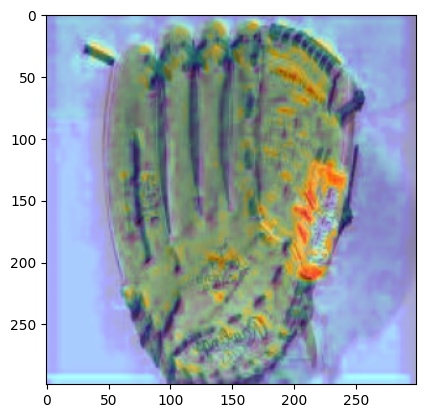

In [20]:
for i in model.layer1:
    cam = GradCAM(model, i)
    heatmap, pred_class = cam.generate(img)
show_cam_on_image(img.cpu(), heatmap)
cam.remove_hooks()

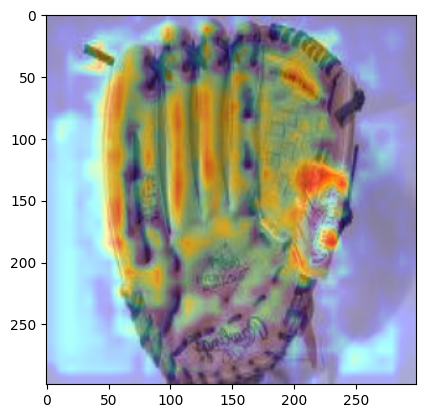

In [21]:
for i in model.layer2:
    cam = GradCAM(model, i)
    heatmap, pred_class = cam.generate(img)
show_cam_on_image(img.cpu(), heatmap)
cam.remove_hooks()

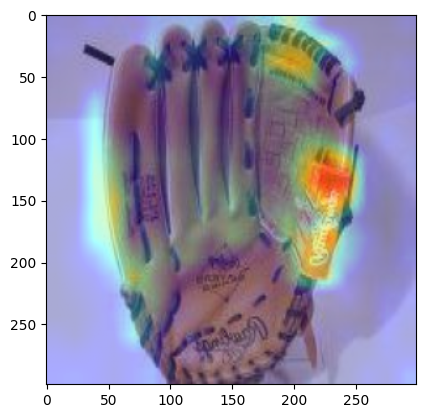

In [22]:
for i in model.layer3:
    cam = GradCAM(model, i)
    heatmap, pred_class = cam.generate(img)
show_cam_on_image(img.cpu(), heatmap)
cam.remove_hooks()

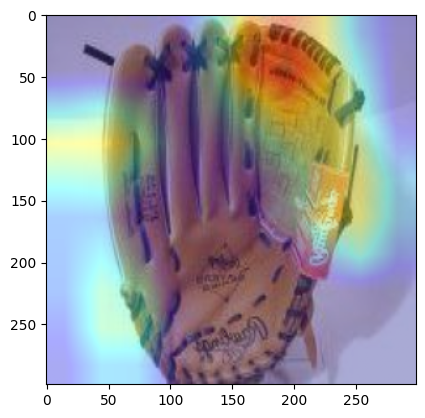

In [23]:
for i in model.layer4:
    cam = GradCAM(model, i)
    heatmap, pred_class = cam.generate(img)
show_cam_on_image(img.cpu(), heatmap)
cam.remove_hooks()